# LE2 – Systemdynamiksimulation: Ameisen, Habitat & Schädlinge (Schweiz)

**Modul:** mss – Modellierung und Simulation komplexer Systeme  
**LE2:** Von der Systemkarte zur Systemdynamik  
**Thema:** *Waldameisen (A), Habitatqualität (H), Schädlingsdruck (S)*

Dieses Notebook setzt die in **LE1** erstellte Systemkarte in ein **Systemdynamik-Modell** um.
Es verwendet bewusst **einfache, transparente Gleichungen** (Euler-Integration), damit du die
Dynamik schrittweise verstehen, kommentieren und erweitern kannst.

> Wenn du **BPTK-Py** installiert hast, findest du weiter unten eine Zelle, die zeigt,
> wie du die Parameter-/Szenariostruktur 1:1 dort abbilden kannst.


## ✅ LE2-Checkliste
- Simulationsmodell mit Anfangszustand (Stocks/Flows)
- Bezug zu LE1-Systemgrenzen (Ameisen, Habitat, Schädlinge; Einflüsse: Klima, Naturschutz, Pestizide)
- Grafiken der zeitlichen Entwicklung in die Zukunft
- Parameter & Annahmen dokumentiert (siehe unten)
- Backtest/Plausibilität: Bandbreiten/Sensitivität/Trends
- Erkenntnisse am Ende


## 📐 Modellgleichungen (vereinfachtes SD‑Modell)

**Stocks:**  
- $A(t)$: Ameisenpopulation (0–1)  
- $H(t)$: Habitatqualität (0–1)  
- $S(t)$: Schädlingsdruck (0–1)  

Die zeitdiskreten Update‑Gleichungen (Euler‑Integration, Schrittweite $dt$):

$$
A_{t+1} = A_t + dt\cdot\left[ r_A\, A_t\, f(H_t) - m_A\, A_t - p\, Pesti\, A_t - c\, A_t\, S_t \right]
$$

$$
H_{t+1} = H_t + dt\cdot\left[ \alpha\, NS - \beta\, Frag - \gamma\, Klima - \delta\, S_t\, H_t \right]
$$

$$
S_{t+1} = S_t + dt\cdot\left[ r_S\, S_t - k\, A_t\, S_t - u\, Pesti\, S_t \right]
$$

mit

$$
f(H) = \dfrac{H}{H + h_{\mathrm{half}}}.
$$


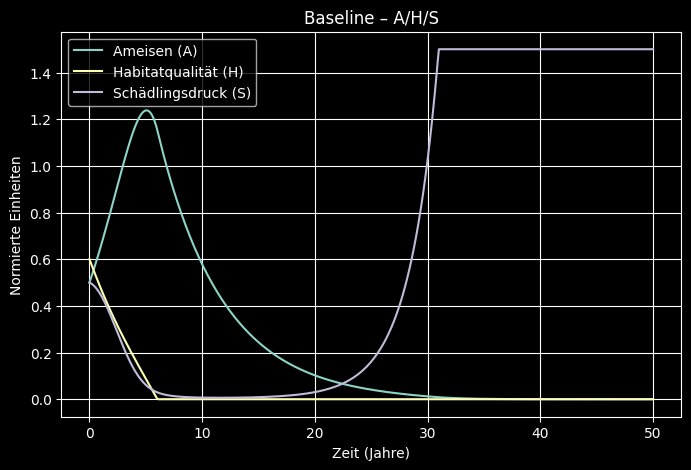

In [1]:
import numpy as np
import matplotlib.pyplot as plt

params = dict(
    r_A=0.8, m_A=0.15, p=0.05, c=0.15,
    r_S=0.6, k=0.9, u=0.5,
    alpha=0.3, beta=0.25, gamma=0.2, delta=0.15,
    h_half=0.3
)

scenarios = {
    "Baseline": dict(NS=0.4, Frag=0.5, Klima=0.4, Pesti=0.4),
    "Naturschutz_plus": dict(NS=0.8, Frag=0.5, Klima=0.4, Pesti=0.3),
    "Weniger_Pestizide": dict(NS=0.5, Frag=0.5, Klima=0.4, Pesti=0.1),
    "Mehr_KlimaStress": dict(NS=0.4, Frag=0.5, Klima=0.8, Pesti=0.4),
    "Fragmentierung_hoch": dict(NS=0.4, Frag=0.8, Klima=0.4, Pesti=0.4),
}

def f_H(H, h_half):
    return H / (H + h_half + 1e-9)

def simulate(T=50, dt=0.1, A0=0.5, H0=0.6, S0=0.5, pars=None, scen=None):
    if pars is None: pars = params
    if scen is None: scen = scenarios["Baseline"]
    n = int(T/dt) + 1
    t = np.linspace(0, T, n)
    A = np.zeros(n); H = np.zeros(n); S = np.zeros(n)
    A[0], H[0], S[0] = A0, H0, S0

    r_A, m_A, p, c = pars["r_A"], pars["m_A"], pars["p"], pars["c"]
    r_S, k, u = pars["r_S"], pars["k"], pars["u"]
    alpha, beta, gamma, delta = pars["alpha"], pars["beta"], pars["gamma"], pars["delta"]
    h_half = pars["h_half"]

    NS, Frag, Klima, Pesti = scen["NS"], scen["Frag"], scen["Klima"], scen["Pesti"]

    for i in range(n-1):
        a, h, s = A[i], H[i], S[i]

        growth_A = r_A * a * f_H(h, h_half)
        loss_A = (m_A + p*Pesti) * a + c * a * s
        dA = growth_A - loss_A

        regen_H = alpha * NS
        loss_H = beta * Frag + gamma * Klima + delta * s * h
        dH = regen_H - loss_H

        growth_S = r_S * s
        loss_S = k * a * s + u * Pesti * s
        dS = growth_S - loss_S

        A[i+1] = max(0.0, min(1.5, a + dt*dA))
        H[i+1] = max(0.0, min(1.0, h + dt*dH))
        S[i+1] = max(0.0, min(1.5, s + dt*dS))

    return t, A, H, S

def plot_series(t, A, H, S, title="Zeitverläufe"):
    plt.figure(figsize=(8,5))
    plt.plot(t, A, label="Ameisen (A)")
    plt.plot(t, H, label="Habitatqualität (H)")
    plt.plot(t, S, label="Schädlingsdruck (S)")
    plt.xlabel("Zeit (Jahre)")
    plt.ylabel("Normierte Einheiten")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Baseline
t, A, H, S = simulate()
plot_series(t, A, H, S, title="Baseline – A/H/S")


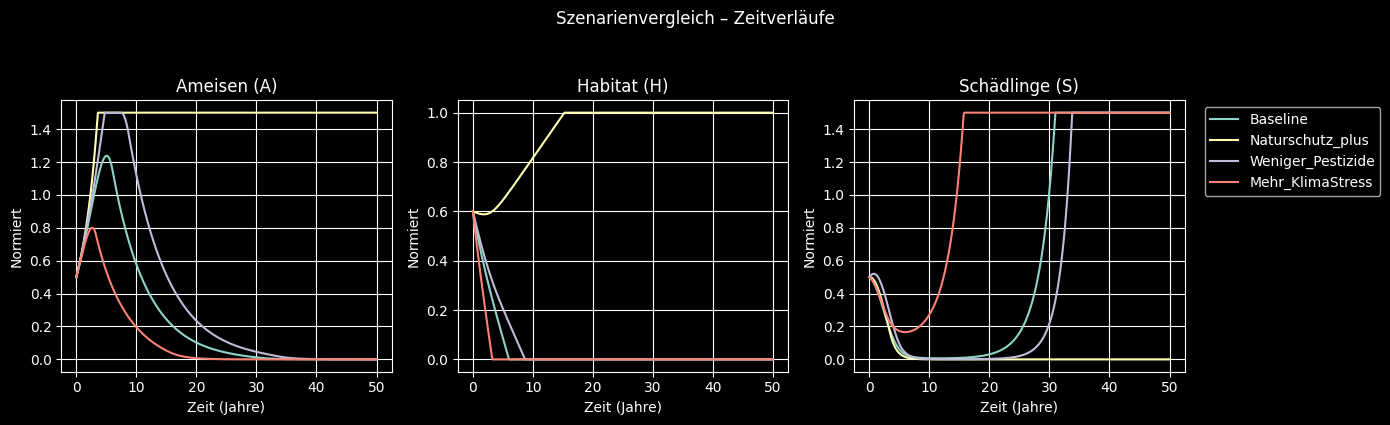

In [2]:
compare = ["Baseline", "Naturschutz_plus", "Weniger_Pestizide", "Mehr_KlimaStress"]
T, dt = 50, 0.1

fig, axes = plt.subplots(1, 3, figsize=(14,4), sharex=True)
for name in compare:
    t, A, H, S = simulate(T=T, dt=dt, scen=scenarios[name])
    axes[0].plot(t, A, label=name)
    axes[1].plot(t, H, label=name)
    axes[2].plot(t, S, label=name)

axes[0].set_title("Ameisen (A)"); axes[1].set_title("Habitat (H)"); axes[2].set_title("Schädlinge (S)")
for ax in axes:
    ax.set_xlabel("Zeit (Jahre)"); ax.grid(True)
axes[0].set_ylabel("Normiert"); axes[1].set_ylabel("Normiert"); axes[2].set_ylabel("Normiert")
axes[2].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.suptitle("Szenarienvergleich – Zeitverläufe", y=1.05)
plt.tight_layout()
plt.show()


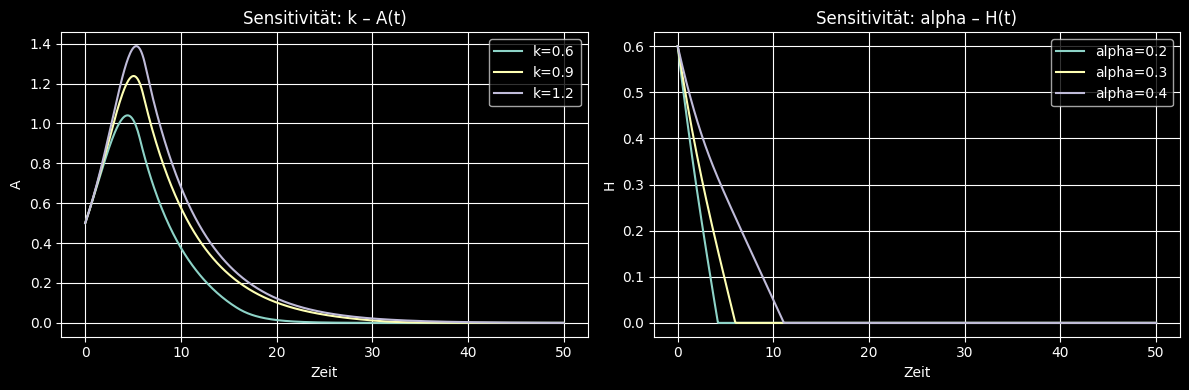

In [3]:
# Sensitivität: k (Kontrolle durch Ameisen) und alpha (Naturschutzwirkung)
ks = [0.6, 0.9, 1.2]
alphas = [0.2, 0.3, 0.4]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for k_val in ks:
    pars = params.copy(); pars["k"] = k_val
    t, A, H, S = simulate(pars=pars)
    plt.plot(t, A, label=f"k={k_val}")
plt.title("Sensitivität: k – A(t)"); plt.xlabel("Zeit"); plt.ylabel("A"); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
for a_val in alphas:
    pars = params.copy(); pars["alpha"] = a_val
    t, A, H, S = simulate(pars=pars)
    plt.plot(t, H, label=f"alpha={a_val}")
plt.title("Sensitivität: alpha – H(t)"); plt.xlabel("Zeit"); plt.ylabel("H"); plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()


Exception in thread Thread-8 (__simulate):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1075, in _bootstrap_inner
Exception in thread Thread-9 (__simulate):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1075, in _bootstrap_inner
Exception in thread Thread-10 (__simulate):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\FHNW\mss\mss_ameisen\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 788, in run_closure
    self.run()
  File "c:\FHNW\mss\mss_ameisen\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 788, in run_closure
Exception in thread Thread-11 (__simulate):
Traceback (most 

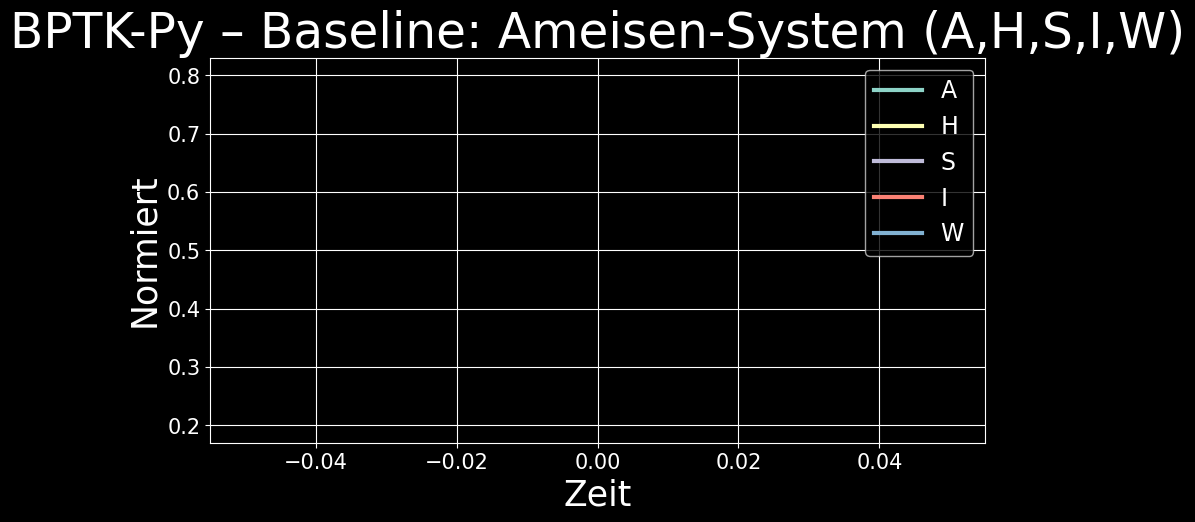

Exception in thread Thread-13 (__simulate):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\FHNW\mss\mss_ameisen\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 788, in run_closure
Exception in thread Thread-14 (__simulate):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1075, in _bootstrap_inner
Exception in thread Thread-15 (__simulate):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\FHNW\mss\mss_ameisen\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 788, in run_closure
    self.run()
  File "c:\FHNW\mss\mss_ameisen\.venv\Lib\s

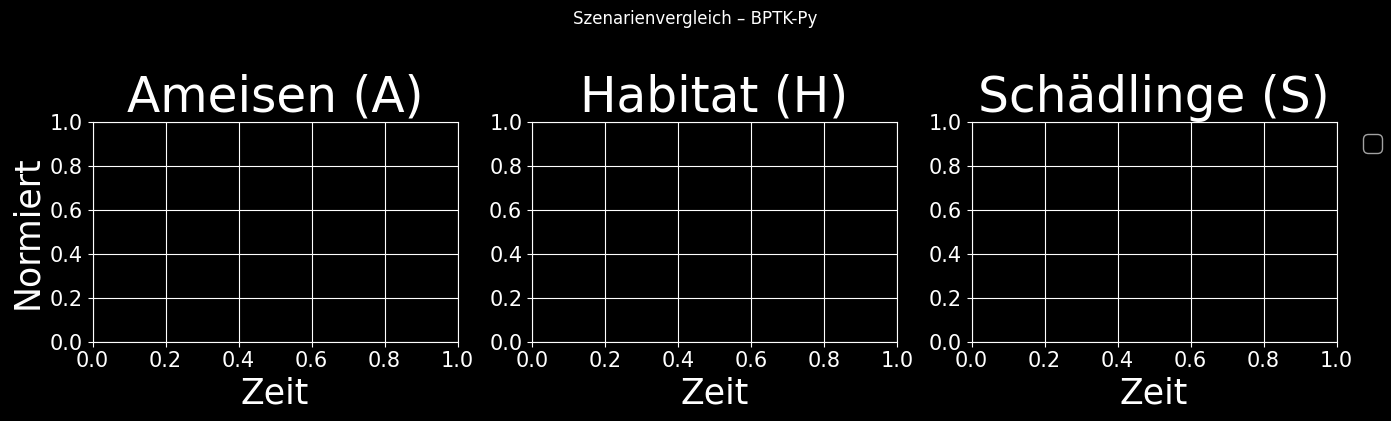

In [23]:
# --- System Dynamics (BPTK-Py) für "Ameisen in der Schweiz" ---
# Kompatibel mit BPTK-Py ≥ 2.x – SD-Workflow über bptk (kein model.run/build)

import sys, subprocess

def ensure_bptk_py():
    try:
        from BPTK_Py import Model
        import BPTK_Py  # for bptk helper
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "BPTK-Py"])
    from BPTK_Py import Model
    import BPTK_Py
    return Model, BPTK_Py

Model, BPTK_Py = ensure_bptk_py()

# ----------------------------------------
# 1️⃣  Modell initialisieren
# ----------------------------------------
model = Model(starttime=0.0, stoptime=50.0, dt=0.1, name="ants_sd")

# Stocks (initial values)
A = model.stock("A"); A.initial_value = 0.5   # Ameisenpopulation
H = model.stock("H"); H.initial_value = 0.6   # Habitatqualität
S = model.stock("S"); S.initial_value = 0.5   # Schädlingsdruck
I = model.stock("I"); I.initial_value = 0.2   # Invasive Arten
W = model.stock("W"); W.initial_value = 0.8   # Waldstabilität

# ----------------------------------------
# 2️⃣  Konstanten & Treiber
# ----------------------------------------
constants = {
    "r_A":0.8, "m_A":0.15, "p":0.05, "c":0.15,             # Ameisen
    "r_S":0.6, "k":0.9, "u":0.5,                           # Schädlinge
    "alpha":0.3, "beta":0.25, "gamma":0.2, "delta":0.15,   # Habitat
    "r_I":0.3, "comp_AI":0.4, "clim_I":0.3,                # Invasive Arten
    "omega":0.2, "chi":0.1,                                # Wald
    "h_half":0.3                                           # Sättigung
}
for k,v in constants.items():
    model.constant(k).equation = v

# Basis-Treiber (werden in Szenarien überschrieben)
base_drivers = {"Naturschutz":0.4, "Fragmentierung":0.5, "Klima":0.4, "Pestizideinsatz":0.4}
for drv, val in base_drivers.items():
    model.constant(drv).equation = val

# ----------------------------------------
# 3️⃣  Konverter & Gleichungen
# ----------------------------------------
model.converter("fH").equation = "H/(H + h_half)"  # Sättigung

# Ameisen (R1)
model.converter("growth_A").equation = "r_A * A * fH"
model.converter("loss_A").equation   = "(m_A + p*Pestizideinsatz)*A + c*A*S + comp_AI*I*A"
model.converter("dA").equation       = "growth_A - loss_A"

# Habitat (B1)
model.converter("regen_H").equation = "alpha*Naturschutz"
model.converter("loss_H").equation  = "beta*Fragmentierung + gamma*Klima + delta*S*H"
model.converter("dH").equation      = "regen_H - loss_H"

# Schädlingsdruck
model.converter("growth_S").equation = "r_S*S"
model.converter("loss_S").equation   = "k*A*S + u*Pestizideinsatz*S"
model.converter("dS").equation       = "growth_S - loss_S"

# Invasive Arten (R2)
model.converter("dI").equation = "r_I*I + clim_I*Klima - 0.3*A*I"

# Waldstabilität
model.converter("dW").equation = "omega*H*A - chi*Klima*W"

# Stocks mit Converter-Objekten verknüpfen (Objekte, keine Strings!)
A.equation = model.converter("dA")
H.equation = model.converter("dH")
S.equation = model.converter("dS")
I.equation = model.converter("dI")
W.equation = model.converter("dW")

# ----------------------------------------
# 4️⃣  SD korrekt ausführen: bptk-Workflow (registrieren + plot_scenarios)
# ----------------------------------------
bptk = BPTK_Py.bptk()             # high-level facade
bptk.register_model(model)        # SD: register model (no scheduler/run needed) :contentReference[oaicite:2]{index=2}

# Szenario-Manager anlegen (Basiswerte)
scenario_manager = {
    "smAnts": {
        "model": model,
        "base_constants": {**constants, **base_drivers}
    }
}
bptk.register_scenario_manager(scenario_manager)  # :contentReference[oaicite:3]{index=3}

# Szenarien definieren & registrieren
scenarios = {
    "Baseline":          {"constants": {"Naturschutz":0.4, "Fragmentierung":0.5, "Klima":0.4, "Pestizideinsatz":0.4}},
    "Naturschutz_plus":  {"constants": {"Naturschutz":0.8, "Fragmentierung":0.5, "Klima":0.4, "Pestizideinsatz":0.3}},
    "Weniger_Pestizide": {"constants": {"Naturschutz":0.5, "Fragmentierung":0.5, "Klima":0.4, "Pestizideinsatz":0.1}},
    "Mehr_KlimaStress":  {"constants": {"Naturschutz":0.4, "Fragmentierung":0.5, "Klima":0.8, "Pestizideinsatz":0.4}},
}
bptk.register_scenarios(scenarios=scenarios, scenario_manager="smAnts")  # :contentReference[oaicite:4]{index=4}

# ----------------------------------------
# 5️⃣  Läufe & Plots – Rückgabe als DataFrame
# ----------------------------------------
import pandas as pd, matplotlib.pyplot as plt

# Baseline-Run (führt die SD-Simulation aus und liefert DataFrame)
df_base = bptk.plot_scenarios(
    scenarios="Baseline",
    scenario_managers="smAnts",
    equations=["A","H","S","I","W"],
    return_df=True
)   # :contentReference[oaicite:5]{index=5}

# Plot Baseline
ax = df_base[["A","H","S","I","W"]].plot(figsize=(10,5), title="BPTK-Py – Baseline: Ameisen-System (A,H,S,I,W)")
ax.set_xlabel("Zeit"); ax.set_ylabel("Normiert"); ax.grid(True)
plt.show()

# Multi-Szenario-Vergleich (A/H/S)
df_multi = bptk.plot_scenarios(
    scenarios=["Baseline","Naturschutz_plus","Weniger_Pestizide","Mehr_KlimaStress"],
    scenario_managers="smAnts",
    equations=["A","H","S"],
    return_df=True
)

fig, axes = plt.subplots(1, 3, figsize=(14,4), sharex=True)
for name, dfi in df_multi.items():   # bptk returns a dict of DFs per equation/scenario set
    if isinstance(dfi, pd.DataFrame) and all(c in dfi.columns for c in ["A","H","S"]):
        axes[0].plot(dfi.index, dfi["A"], label=name)
        axes[1].plot(dfi.index, dfi["H"], label=name)
        axes[2].plot(dfi.index, dfi["S"], label=name)

axes[0].set_title("Ameisen (A)")
axes[1].set_title("Habitat (H)")
axes[2].set_title("Schädlinge (S)")
for ax_ in axes:
    ax_.set_xlabel("Zeit"); ax_.grid(True)
axes[0].set_ylabel("Normiert")
axes[2].legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.suptitle("Szenarienvergleich – BPTK-Py", y=1.04)
plt.tight_layout()
plt.show()



### Zelle 8 — Erkenntnisse
```markdown
## 📝 Erkenntnisse – Platzhalter
- Trage hier deine Beobachtungen aus den Szenarien-/Sensitivitätsläufen ein.
